# Урок: Рекуррентные нейронные сети

## Задание: 

* Попробуйте изменить параметры нейронной сети, работающей с датасетом imdb, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить её точность. Приложите анализ

## Импорт библиотек

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Датасет

### Ссылка: [Kaggle. Daily Climate time series data](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)

### Описание:
The Dataset is fully dedicated for the developers who want to train the model on Weather Forecasting for Indian climate. This dataset provides data from 1st January 2013 to 24th April 2017 in the city of Delhi, India.
The 4 parameters here are:

* meantemp
* humidity
* wind_speed
* meanpressure


In [2]:
drive.mount('/content/drive')

df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/DailyDelhiClimateTest.csv')

Mounted at /content/drive


In [3]:
df_train.sort_values(by='date', ascending=False).head()

,date,meantemp,humidity,wind_speed,meanpressure
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217


In [4]:
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


## Трансформация данных и сдвиг по времени


In [77]:
def transform(df: pd.DataFrame) -> pd.DataFrame:
  df_ = df.copy()
  df_.index = df_.date
  df_['date_'] = pd.to_datetime(df_['date'], format='%Y-%m-%d')
  df_['month'] = pd.DatetimeIndex(df_['date_']).month
  df_['day'] = pd.DatetimeIndex(df_['date_']).day
  df_['weekday'] = pd.DatetimeIndex(df_['date_']).weekday
  df_.drop(['date', 'date_', 'meanpressure'], axis=1, inplace=True)
  return df_


df_train_proc = transform(df_train)
df_test_proc = transform(df_test)

for f in ['meantemp', 'humidity', 'wind_speed']:
  std_scaler = StandardScaler()
  df_train_proc[f] = std_scaler.fit_transform(df_train_proc[[f]])
  df_test_proc[f] = std_scaler.transform(df_test_proc[[f]])

# сбрасываем индекс у train и test
df_train_proc.reset_index(drop=True, inplace=True)
df_test_proc.reset_index(drop=True, inplace=True)

# сдвиг будем делать на неделю
X_LEN = 7

# отрезаем у train с конца X_LEN наблюдений
df_train_proc = df_train_proc.iloc[:-X_LEN, :]

# индексируем test, начиная с последнего индекса train
ind = df_train_proc.index[-1] + X_LEN
df_test_proc.index += ind

column_number = len(df_train_proc.columns)
future = 1

start = future + X_LEN - 1
end = -future - X_LEN + 1

train_df = df_train_proc.iloc[:end, :]
X_train = train_df[[df_train_proc.columns[i] for i in range(column_number)]].values
y_train = df_train_proc.iloc[start:, 0].values

test_df = df_test_proc.iloc[:end,:]
X_test = test_df[[df_test_proc.columns[i] for i in range(column_number)]].values
y_test = df_test_proc.iloc[start:, 0].values

In [78]:
X_train[:14,0]

array([-2.10950001, -2.46345392, -2.49521901, -2.29101484, -2.65404448,
       -2.51790837, -2.51790837, -2.26508415, -1.56495555, -1.9733639 ,
       -1.33157934, -1.56495555, -1.31537266, -1.72378102])

In [79]:
y_train[:14]

array([-2.26508415, -1.56495555, -1.9733639 , -1.33157934, -1.56495555,
       -1.31537266, -1.72378102, -1.46771546, -1.5876449 , -1.22461525,
       -1.5876449 , -1.76915972, -1.93446786, -1.94613667])

## Визуализация данных

In [80]:
print(f"X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"X_test: {X_test.shape} y_test: {y_test.shape}")

X_train: (1448, 6) y_train: (1448,)
X_test: (107, 6) y_test: (107,)


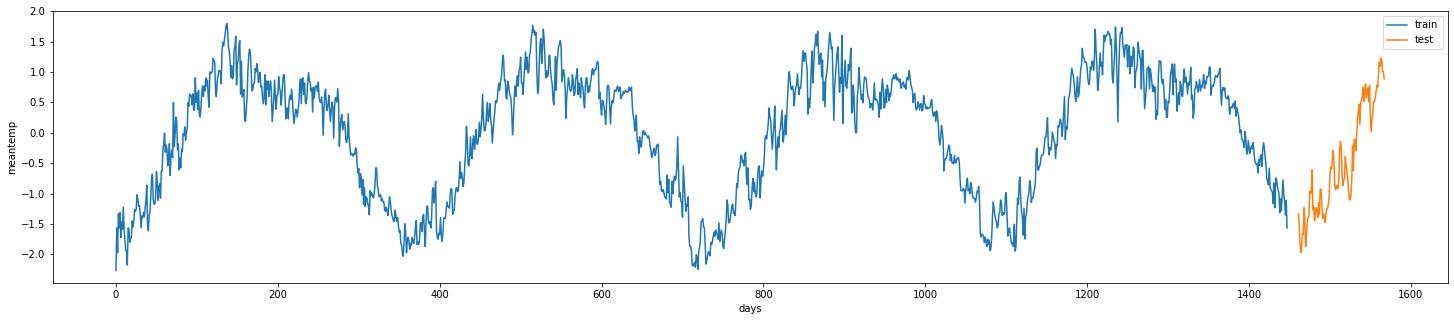

In [81]:
plt.figure(figsize=(25,5))
plt.plot(train_df.index, y_train[:], label='train')
plt.plot(test_df.index, y_test[:], label='test')

plt.xlabel('days')
plt.ylabel('meantemp')
plt.legend()
plt.show()

In [126]:
BATCH_SIZE = 32
EPOCHS = 30

train_data = keras.preprocessing.timeseries_dataset_from_array(
  X_train,
  y_train,
  sequence_length=X_LEN,
  sampling_rate=1,
  batch_size=BATCH_SIZE,
)

val_data = keras.preprocessing.timeseries_dataset_from_array(
  X_test,
  y_test,
  sequence_length=X_LEN,
  sampling_rate=1,
  batch_size=BATCH_SIZE,
)

In [127]:
for batch in val_data.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 7, 6)
Target shape: (32,)


## Конфигурация модели

In [151]:
model = Sequential()
model.add(LSTM(32, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(Flatten())
model.add(Dense(3, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(
  loss="mse",
  optimizer="nadam",
  metrics=['mae']
)

model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 7, 32)             4992      
_________________________________________________________________
flatten_36 (Flatten)         (None, 224)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 3)                 675       
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 4         
Total params: 5,671
Trainable params: 5,671
Non-trainable params: 0
_________________________________________________________________


## Обучение

Epoch 1/30
46/46 [==============================] - 3s 18ms/step - loss: 0.8721 - mae: 0.7985 - val_loss: 0.5861 - val_mae: 0.6688
Epoch 2/30
46/46 [==============================] - 0s 10ms/step - loss: 0.4819 - mae: 0.5726 - val_loss: 0.4212 - val_mae: 0.5189
Epoch 3/30
46/46 [==============================] - 0s 10ms/step - loss: 0.2483 - mae: 0.4006 - val_loss: 0.3298 - val_mae: 0.4515
Epoch 4/30
46/46 [==============================] - 0s 10ms/step - loss: 0.1593 - mae: 0.3187 - val_loss: 0.2261 - val_mae: 0.3832
Epoch 5/30
46/46 [==============================] - 0s 10ms/step - loss: 0.1183 - mae: 0.2752 - val_loss: 0.1686 - val_mae: 0.3381
Epoch 6/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0996 - mae: 0.2520 - val_loss: 0.1411 - val_mae: 0.3113
Epoch 7/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0895 - mae: 0.2392 - val_loss: 0.1234 - val_mae: 0.2939
Epoch 8/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0828 - m

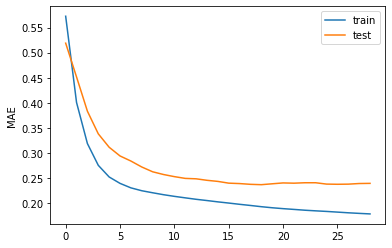

In [152]:
history = model.fit(
  train_data,
  epochs=EPOCHS,
  validation_data=val_data
)

plt.plot(history.history['mae'][1:], label='train')
plt.plot(history.history['val_mae'][1:], label='test')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Проверка модели

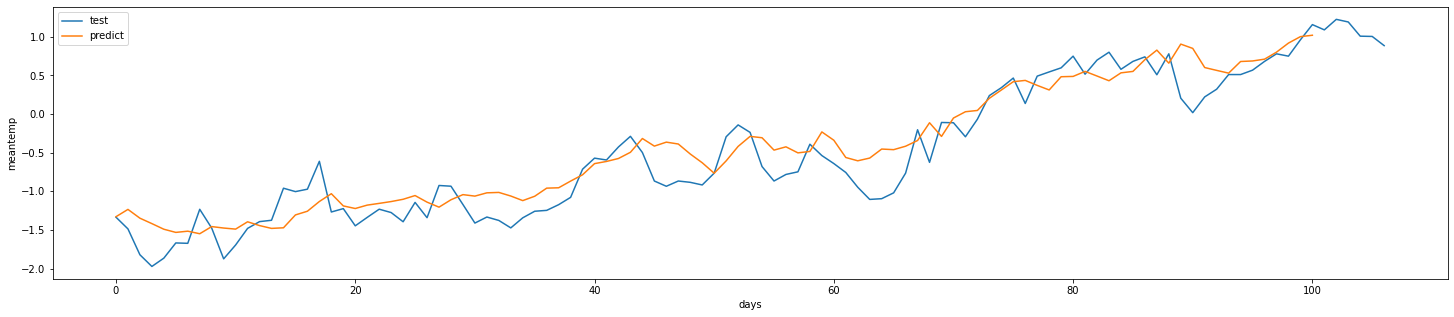

In [153]:
predVal = model.predict(val_data).flatten()

plt.figure(figsize=(25,5))
plt.plot(y_test, label='test')
plt.plot(predVal, label='predict')

plt.xlabel('days')
plt.ylabel('meantemp')
plt.legend()
plt.show()

## Проверка лаговой корреляции

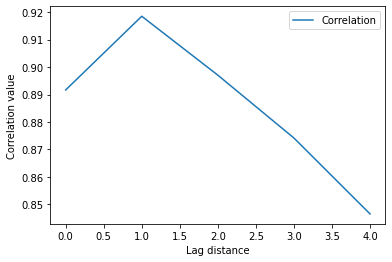

In [154]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val


corr = []
start = 0 # начальная точка для проверки корреляций рядов
step = 80 # число точек для проверки корреляций рядов

yValF = y_test[start:start+step] # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 

for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, label='Correlation')
plt.xlabel('Lag distance')
plt.ylabel('Correlation value')
plt.legend()
plt.show()